In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

## Internal Links ##
- Vaccinations, Cases, Deaths [casevax_df](#build_casevax).

- Statewide Stats [us_df](#build_us_df)

### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"

Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
use_cached_files = True

confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"

county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"

#CDC Data: https://catalog.data.gov/dataset/covid-19-vaccinations-in-the-united-statescounty

#//***********************************************************************************************
#//*** California COVID Data website:
#//**************************************
#//*** https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
#//***********************************************************************************************

#//*** Download California Current COVID Demograohic Data
if not use_cached_files:
    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
        if response.ok:
            print("US Confirmed Data Downloaded")
            f = open(confirmed_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Confirmed Data Written to file.")
    except:
        print("US Confirmed Data: Trouble Downloading From Johns Hopkins Github")

    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
        if response.ok:
            print("US Deaths Data Downloaded")
            f = open(death_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Death Data Written to file.")
    except:
        print("US Death Data: Trouble Downloading From Johns Hopkins Github")
        
    try:
        #response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        response = requests.get("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("Vaccination Data Downloading")
            f = open(vaccine_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Vaccination Data Written to file.")
    except:
        print("US Vaccine Data: Trouble Downloading From CDC")

    try:
        #//*** CDC Vaccination County Data
        #//*** Source: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh
        response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("County Vaccination Data Downloading")
            #//*** Write CSV File
            f = open(county_vaccine_data_filename.replace(".zip",""), "w")
            f.write(response.text)
            f.close()

            #//*** File > 100 mb
            #//*** read the CSV into a Dataframe and pickle the file with compression
            pd.read_csv(county_vaccine_data_filename.replace(".zip","")).to_pickle(county_vaccine_data_filename)

            #//*** Delete the Original CSV File
            os.remove(county_vaccine_data_filename.replace(".zip",""))

            print("US County Vaccination Data Written to file.")
    except:
        print("US County Vaccine Data: Trouble Downloading From CDC")    


#confirm_df = pd.read_csv(confirmed_data_filename, dtype={"FIPS":np.int32})


In [5]:

#if use_cached_files:
#if True:
#//*** Load Locally stored data
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
print("Loading Cached: confirm_df")
attrib_death_df = pd.read_pickle(attrib_death_filename)
print("Loading Cached: death_df")

print("Load Geo Vaccine Data")
geo_vax_df = pd.read_pickle(geo_vax_filename)

print("Load Casevax_df: Combined Case, Death, Vaccination Data ")
casevax_df = pd.read_pickle(casevax_filename)

#//**** Load death Data
#death_df = pd.read_csv(death_data_filename)
#confirm_df = pd.read_csv(confirmed_data_filename)   
#confirm_df = confirm_df.dropna(subset=["FIPS"])

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']
print("Loading Cached: all_dates")
#else:
#    print("Re-Building Data...")
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//*** Rename Columns to sync dataframes by FIPS/GEOID

ren_cols = {
    "FIPS" : "GEOID"
}

#//*********************************
#//*** Rename Confirmed Cols
#//*********************************

#//*** Get columns
cols = np.array(confirm_df.columns)

#//*** Rplace Values
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)

#//*** update columns
confirm_df.columns = cols

#//*********************************
#//*** Rename Death Cols
#//*********************************
#//*** Get columns
cols = np.array(death_df.columns)

#//*** Replace Values
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)

#//*** update columns
death_df.columns = cols


confirm_df["GEOID"] = confirm_df["GEOID"].astype(int)
death_df["GEOID"] =   death_df["GEOID"].astype(int)

#//*** US States Only. Lose the Territories
confirm_df = confirm_df[confirm_df['iso3'] == 'USA']
death_df = death_df[death_df['iso3'] == 'USA']


#//*** Get Shape File
states = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
states = states[['STATEFP','GEOID','NAME','geometry']]


states['GEOID'] = states['GEOID'].astype(int)

#//*** Merge with Shapes
confirm_df = states.merge(confirm_df,left_on="GEOID",right_on="GEOID")
death_df = states.merge(death_df,left_on="GEOID",right_on="GEOID")

#//*** Remove Extra Columns
rem_cols = ['iso2','iso3','code3',"Admin2","Country_Region","Lat","Long_","UID"]

cols = list(confirm_df.columns)

for col in rem_cols:
    cols.remove(col)

confirm_df = confirm_df[cols]

cols = list(death_df.columns)

for col in rem_cols:
    cols.remove(col)

death_df = death_df[cols]

#//*** Convert Cumulative Cases to Daily Cases
confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
death_df[death_df.columns[7:]]     = death_df[death_df.columns[7:]].diff(axis = 1, periods = 1)

#//*** Convert to 7-day Rolling Mean of New Cases
confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].rolling(7,axis=1).mean()
death_df[death_df.columns[7:]] = death_df[death_df.columns[7:]].rolling(7,axis=1).mean()


#//*** Remove the single na column
confirm_df = confirm_df.dropna(axis=1)
death_df = death_df.dropna(axis=1)



#//**** Merge Population with confirm. Pop_df is first to keep population stats away from the data columns that are added sequentially every day
confirm_df = confirm_df.merge(death_df[['GEOID','Population']].copy(),left_on="GEOID",right_on="GEOID")

#//*** Generate population 100k values
confirm_df['pop_100k'] = confirm_df['Population'] / 100000
death_df['pop_100k'] = death_df['Population'] / 100000

#//*** Filter out Hawaii and Alaska
confirm_df = confirm_df[confirm_df["Province_State"] != "Hawaii"]
confirm_df = confirm_df[confirm_df["Province_State"] != "Alaska"]

death_df = death_df[death_df["Province_State"] != "Hawaii"]
death_df = death_df[death_df["Province_State"] != "Alaska"]

print("Done!")


Loading Cached: confirm_df
Loading Cached: death_df
Load Geo Vaccine Data
Load Casevax_df: Combined Case, Death, Vaccination Data 
Loading Cached: all_dates
Done!


In [6]:
death_df

STATEFP  GEOID      NAME                                           geometry  Province_State                Combined_Key  Population  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina, US       32722      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina, US       62806      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio, US      541013      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania, US        6066      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas, US       41753      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
...      ...    ...       ...                                                ...             ...                         ...         ...      ...      ...      ...     ...     ...     ...     ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana, US       25627      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota, US        6832      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska, US       17284      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina, US       90485      0.0      0.0      0.0     0.0     0.0     0.0     0.0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia, US       29524      0.0      0.0      0.0     0.0     0.0     0.0     0.0   

      2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1        0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2        0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3        0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4        0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...      ...     ...     ...     ...     ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...   
3137     0.0     0.0     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3138    

<a id="build_us_df"></a> 
### Build State Totals: Vaccination, Confirmed, Death ###

In [7]:
#//******************************
#//**** Build State Vaccine Data
#//******************************

#//*** read Raw Vaccine csv
vax_df = pd.read_csv(vaccine_data_filename)
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])


#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
states = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
states = states[['STATEFP','GEOID','NAME','geometry']]

states['GEOID'] = states['GEOID'].astype(int)
states['STATEFP'] = states['STATEFP'].astype(int)

#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
state_fips = pd.read_csv("state_fips.csv")
geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AK" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "HI" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AS" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "GU" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "MP" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "PR" ]
geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "VI" ]

#//*** Merge Geographic Data with Vaccince Data
geo_vax_df = states.merge(geo_vax_df,left_on="STATEFP",right_on="FIPS")

#//*** Round the Vaccination Percentages
geo_vax_df["Series_Complete_Pop_Pct"] = geo_vax_df["Series_Complete_Pop_Pct"].round(1)
geo_vax_df["Administered_Dose1_Pop_Pct"] = geo_vax_df["Administered_Dose1_Pop_Pct"].round(1)

geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))


#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)
    
    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

print(us_deaths_df)
    
us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))    


#//*** Build additional stat values and merge with geo_vax_df
#//*** t_vax_df is a temp dataframe
t_vax_df = pd.DataFrame()
for group in us_df.groupby('state'):
    loop_df = group[1].copy()
    print(loop_df)
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    t_vax_df = pd.concat([t_vax_df,geo_vax_df[geo_vax_df['Name']==group[0]].merge(loop_df,left_on="Date", right_on='Date')])
    

print(t_vax_df[t_vax_df['state']=='California'])
geo_vax_df = t_vax_df.sort_values(by=['NAME',"Date"]).copy()

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}
#//*** Columns to remove
del_cols = [ 
    'Administered_Dose1_Recip_12Plus',
     'Administered_Dose1_Recip_12PlusPop_Pct',
     'Administered_Dose1_Recip_18Plus',
     'Administered_Dose1_Recip_18PlusPop_Pct',
     'Administered_Dose1_Recip_65Plus',
     'Administered_Dose1_Recip_65PlusPop_Pct',
     'Series_Complete_12Plus',
     'Series_Complete_12PlusPop_Pct',
     'Series_Complete_18Plus',
     'Series_Complete_18PlusPop_Pct',
     'Series_Complete_65Plus',
     'Series_Complete_65PlusPop_Pct',]
vax_cols = list(geo_vax_df.columns)

for find,replace in ren_cols.items():
    vax_cols = [replace if i==find else i for i in vax_cols]

geo_vax_df.columns=vax_cols

for col in del_cols:
    if col in geo_vax_df.columns:
        del geo_vax_df[col]

geo_vax_df


#//*** Write vaccinations to file
geo_vax_df.to_pickle(geo_vax_filename)        
print("Geographic Vaccinations Built")

#//*** Temp File Cleanup
del us_deaths_df
del us_df
del t_vax_df

       state population     Date tot_death
0    Alabama    4903185  1/22/20         0
1    Alabama    4903185  1/23/20         0
2    Alabama    4903185  1/24/20         0
3    Alabama    4903185  1/25/20         0
4    Alabama    4903185  1/26/20         0
..       ...        ...      ...       ...
621  Wyoming     578759  10/4/21       996
622  Wyoming     578759  10/5/21      1041
623  Wyoming     578759  10/6/21      1041
624  Wyoming     578759  10/7/21      1041
625  Wyoming     578759  10/8/21      1041

[36308 rows x 4 columns]
       state population       Date tot_death tot_confirm
0    Alabama    4903185 2020-01-22         0           0
1    Alabama    4903185 2020-01-23         0           0
2    Alabama    4903185 2020-01-24         0           0
3    Alabama    4903185 2020-01-25         0           0
4    Alabama    4903185 2020-01-26         0           0
..       ...        ...        ...       ...         ...
621  Alabama    4903185 2021-10-04     14471      801428
62

              state population       Date tot_death tot_confirm
0    Grand Princess          0 2020-01-22         0           0
1    Grand Princess          0 2020-01-23         0           0
2    Grand Princess          0 2020-01-24         0           0
3    Grand Princess          0 2020-01-25         0           0
4    Grand Princess          0 2020-01-26         0           0
..              ...        ...        ...       ...         ...
621  Grand Princess          0 2021-10-04         3         103
622  Grand Princess          0 2021-10-05         3         103
623  Grand Princess          0 2021-10-06         3         103
624  Grand Princess          0 2021-10-07         3         103
625  Grand Princess          0 2021-10-08         3         103

[626 rows x 5 columns]
    state population       Date tot_death tot_confirm
0    Guam     164229 2020-01-22         0           0
1    Guam     164229 2020-01-23         0           0
2    Guam     164229 2020-01-24         0     

         state population       Date tot_death tot_confirm
0    Minnesota    5639632 2020-01-22         0           0
1    Minnesota    5639632 2020-01-23         0           0
2    Minnesota    5639632 2020-01-24         0           0
3    Minnesota    5639632 2020-01-25         0           0
4    Minnesota    5639632 2020-01-26         0           0
..         ...        ...        ...       ...         ...
621  Minnesota    5639632 2021-10-04      8191      718327
622  Minnesota    5639632 2021-10-05      8191      725451
623  Minnesota    5639632 2021-10-06      8243      729334
624  Minnesota    5639632 2021-10-07      8275      732001
625  Minnesota    5639632 2021-10-08      8295      735646

[626 rows x 5 columns]
           state population       Date tot_death tot_confirm
0    Mississippi    2976149 2020-01-22         0           0
1    Mississippi    2976149 2020-01-23         0           0
2    Mississippi    2976149 2020-01-24         0           0
3    Mississippi    2976

      state population       Date tot_death tot_confirm
0    Oregon    4217737 2020-01-22         0           0
1    Oregon    4217737 2020-01-23         0           0
2    Oregon    4217737 2020-01-24         0           0
3    Oregon    4217737 2020-01-25         0           0
4    Oregon    4217737 2020-01-26         0           0
..      ...        ...        ...       ...         ...
621  Oregon    4217737 2021-10-04      3823      334971
622  Oregon    4217737 2021-10-05      3867      336598
623  Oregon    4217737 2021-10-06      3900      338130
624  Oregon    4217737 2021-10-07      3959      339556
625  Oregon    4217737 2021-10-08      3982      341113

[626 rows x 5 columns]
            state population       Date tot_death tot_confirm
0    Pennsylvania   12801989 2020-01-22         0           0
1    Pennsylvania   12801989 2020-01-23         0           0
2    Pennsylvania   12801989 2020-01-24         0           0
3    Pennsylvania   12801989 2020-01-25         0       

       state population       Date tot_death tot_confirm
0    Wyoming     578759 2020-01-22         0           0
1    Wyoming     578759 2020-01-23         0           0
2    Wyoming     578759 2020-01-24         0           0
3    Wyoming     578759 2020-01-25         0           0
4    Wyoming     578759 2020-01-26         0           0
..       ...        ...        ...       ...         ...
621  Wyoming     578759 2021-10-04       996       91979
622  Wyoming     578759 2021-10-05      1041       92415
623  Wyoming     578759 2021-10-06      1041       93083
624  Wyoming     578759 2021-10-07      1041       93764
625  Wyoming     578759 2021-10-08      1041       94303

[626 rows x 5 columns]
     STATEFP  GEOID        NAME                                           geometry        Name Postal Code  FIPS       Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  \
0          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California        

In [8]:
plot_df = geo_vax_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_df = pd.concat([vax_tier_df,tier_df])

vax_tier_df.dropna(inplace=True)
vax_tier_df = vax_tier_df.reset_index()
print(vax_tier_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_df['tier'].unique())
cats



40.6
70.1
      index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  death_avg_100k  \
0         0 2020-12-28  total_40    12799367                       0                 0       909693      13661      10748         167    16653.571429       238.000000     130.112461        1.859467   
1         0 2020-12-29  total_40    12799367                       0                 0       918884      13814      15279         270    16579.785714       244.214286     129.535982        1.908018   
2         0 2020-12-30  total_40    12799367                       0                 0       930300      13929      20607         268    16684.785714       239.857143     130.356335        1.873977   
3         0 2020-12-31  total_40    12799367                       0                 0       940352      14118      21468         304    16772.428571       235.928571     131.041079    

['total_40', 'total_45', 'total_50', 'total_55', 'total_60', 'total_65']

In [9]:
vax_tier_df[vax_tier_df['tier'] == 'total_40'].reset_index()

level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40    12799367                       0                 0       909693      13661      10748         167    16653.571429       238.000000     130.112461   
1          1      0 2020-12-29  total_40    12799367                       0                 0       918884      13814      15279         270    16579.785714       244.214286     129.535982   
2          2      0 2020-12-30  total_40    12799367                       0                 0       930300      13929      20607         268    16684.785714       239.857143     130.356335   
3          3      0 2020-12-31  total_40    12799367                       0                 0       940352      14118      21468         304    16772.428571       235.928571     131.041079   
4          4      0 2021-01-01  total_40    12799367                       0                 0       950209      14232      19909         303    16594.785714       235.642857     129.653175   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
280      280      0 2021-10-04  total_40    12799367                 5463825           6475848      2025250      33527       7863         109    14159.714286       353.857143     110.628239   
281      281      0 2021-10-05  total_40    12799367                 5479541           6487814      2031737      33721      11826         303    13707.000000       339.214286     107.091233   
282      282      0 2021-10-06  total_40    12799367                 5488253           6495199      2038085      33929      12835         402    13332.428571       320.428571     104.164749   
283      283      0 2021-10-07  total_40    12799367                 5496475           6502814      2044691      34058      12954         337    12936.928571       307.928571     101.074753   
284      284      0 2021-10-08  total_40    12799367                 5511577           6515619      2050724      34295      12639         366    12467.928571       301.785714      97.410509   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.859467                  0.000000        0.000000  
1          1.908018                  0.000000        0.000000  
2          1.873977                  0.000000        0.000000  
3          1.843283                  0.000000        0.000000  
4          1.841051                  0.000000        0.000000  
..              ...                       ...             ...  
280        2.764646                  0.426882        0.505951  
281        2.650243                  0.428110        0.506886  
282        2.503472                  0.428791        0.507463  
283        2.405811                  0.429433        0.508057  
284        2.357817                  0.430613        0.509058  

[285 rows x 17 columns]

In [10]:


category_col = 'tier'
overview_dict = {}
start_date =  vax_tier_df['Date'].min()
end_date =  vax_tier_df['Date'].max()
tot_pop = vax_tier_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_df[vax_tier_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_df[vax_tier_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_df[vax_tier_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
overview_dict

{'total_40': {'population': 12799367,
  'pop_pct': 0.03912043989295825,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 1141031,
  'confirm_start': 909693,
  'confirm_end': 2050724,
  'confirm_period_100k': 8914.745549526004,
  'confirm_deaths': 20634,
  'death_period_100k': 161.21109739255076,
  'vax_complete': 5511577,
  'vax_complete_100k': 43061.32482957946,
  'vax_partial': 6515619,
  'vax_partial_100k': 50905.790887940006,
  'states': ['Alabama',
   'Idaho',
   'Mississippi',
   'North Dakota',
   'West Virginia',
   'Wyoming']},
 'total_45': {'population': 48157305,
  'pop_pct': 0.14718969740139162,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 4238435,
  'confirm_start': 3275442,
  'confirm_end': 7513877,
  'confirm_period_100k': 8801.229636915936,
  'confirm_deaths': 65205,
  'death_period_100k': 135.4000187510493,
  'vax_complete': 2277

In [11]:
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "
    

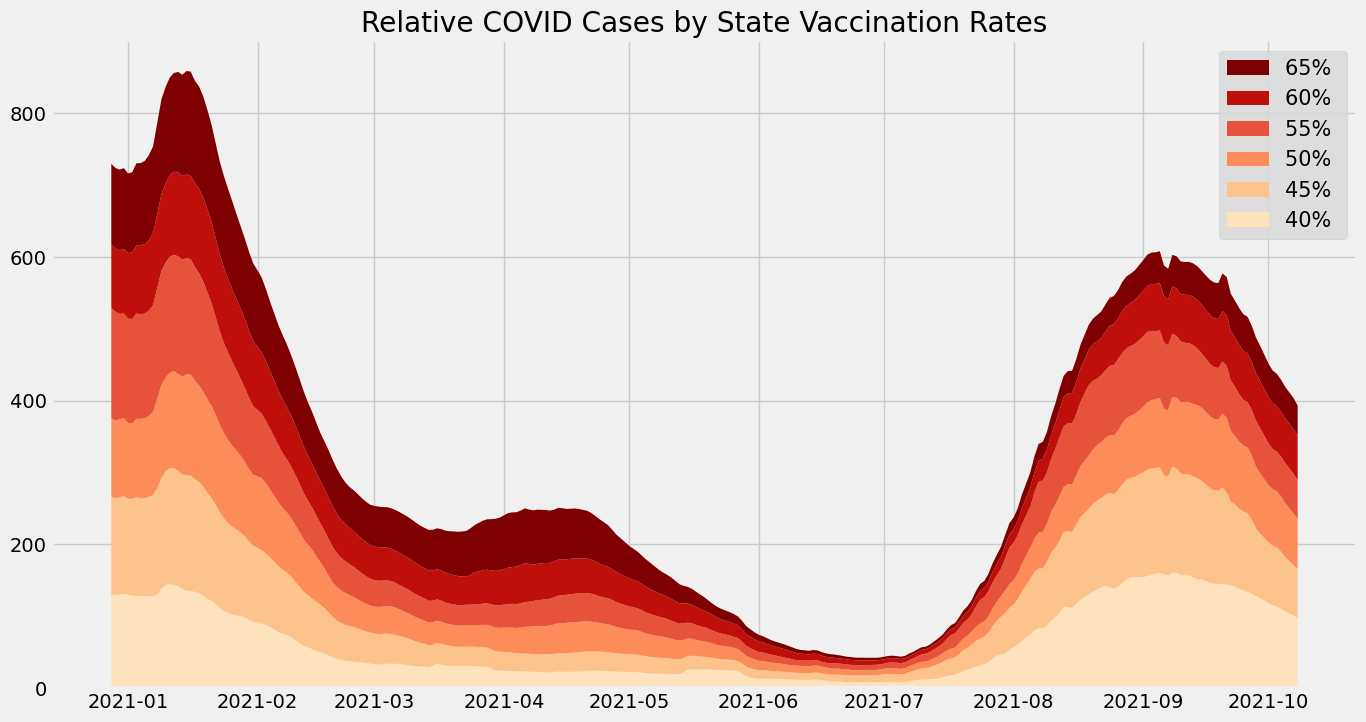

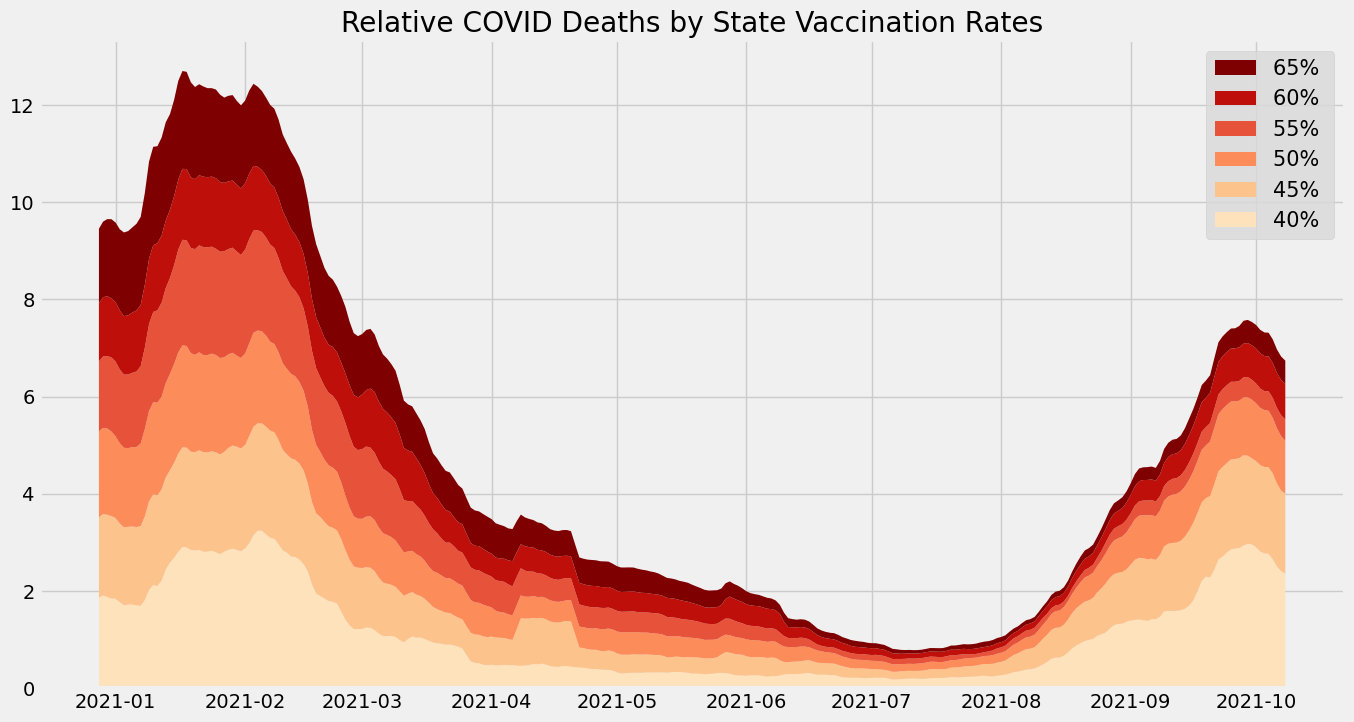

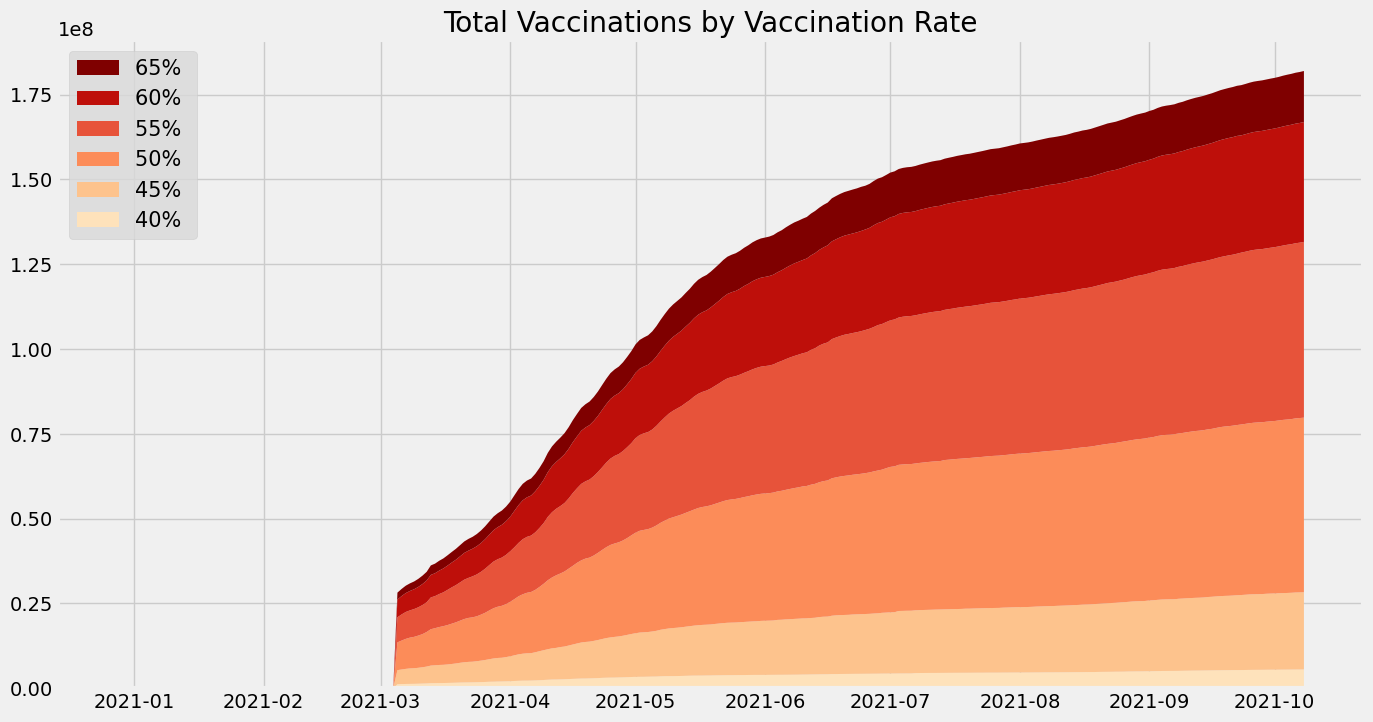

In [12]:
out_exec_summary_images = []

exec_fig_width =15
exec_fig_height=8
fontsize=15

plot_df = vax_tier_df



plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['case_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] = v1

#//*** Get a color Palette
item_count = len(cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)
    
vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Dark2(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

colors = {}
counter = 0
for period in plot_dict.keys():
    colors[period] = colors_palette[counter]
    counter+=1
    
labels=key_label_dict.values()


plt.rcdefaults()
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()


fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)


labels=key_label_dict.values()
ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
             colors=colors_palette,
            )


plt.title('Relative COVID Cases by State Vaccination Rates')
handles = plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize).legendHandles


outfilename='z_exec_summary_relative_covid_rates_by_vax.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)
#handles = plt.legend().legendHandles
plt.show()


plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['death_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)

#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)

labels=key_label_dict.values()


ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
            colors=colors_palette,
            )

plt.title('Relative COVID Deaths by State Vaccination Rates')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize)

outfilename='z_exec_summary_relative_death_rates_by_vax.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_relative_death_rates_by_vax.jpg")
#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['total_vaccinated_count']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)


#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)

labels=key_label_dict.values()

ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
             colors=colors_palette,
            )
plt.title('Total Vaccinations by Vaccination Rate')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=fontsize)

outfilename='z_exec_summary_total_vax_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()

out_exec_summary_images.append("z_exec_summary_total_vax_rates.jpg")

In [13]:
print(handles)
#print(overview_dict['total_40'].keys())

for key,value in overview_dict.items():
    print(f"{key} pop pct:{round(overview_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_dict[key]['vax_complete_100k'])}")

[<matplotlib.patches.Rectangle object at 0x000001D325F2AF10>, <matplotlib.patches.Rectangle object at 0x000001D325F2AC70>, <matplotlib.patches.Rectangle object at 0x000001D325F2A5B0>, <matplotlib.patches.Rectangle object at 0x000001D3261F6730>, <matplotlib.patches.Rectangle object at 0x000001D3261F6C40>, <matplotlib.patches.Rectangle object at 0x000001D3261F6880>]
total_40 pop pct:0.0391 confirm 100k:8914 Death 100k:161 Vaccine 100k:43061
total_45 pop pct:0.1472 confirm 100k:8801 Death 100k:135 Vaccine 100k:47303
total_50 pop pct:0.302 confirm 100k:7451 Death 100k:111 Vaccine 100k:52090
total_55 pop pct:0.2695 confirm 100k:7444 Death 100k:95 Vaccine 100k:58780
total_60 pop pct:0.1738 confirm 100k:6600 Death 100k:84 Vaccine 100k:62152
total_65 pop pct:0.0684 confirm 100k:6799 Death 100k:91 Vaccine 100k:67301


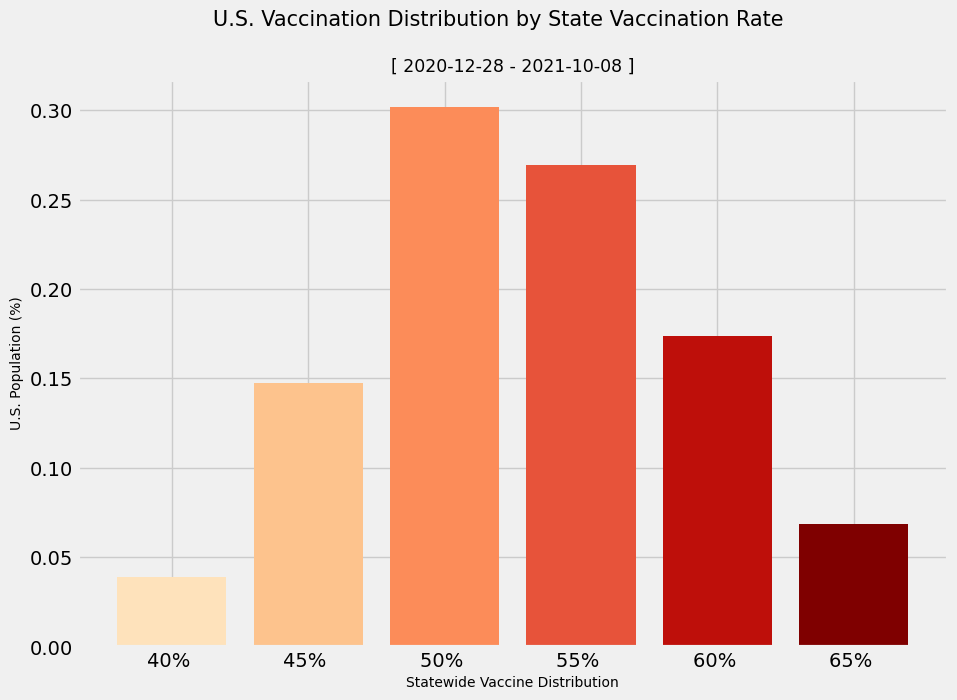

In [14]:
#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = overview_dict.keys()
y_vals = np.array([overview_dict[x]['pop_pct'] for x in overview_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle(f'U.S. Vaccination Distribution by State Vaccination Rate',fontsize=fontsize*1.5)
plt.title(f'[ {start_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("U.S. Population (%)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_vax_distribution.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_vax_distribution.jpg")

In [15]:
overview_dict

vax_tier_df[vax_tier_df['tier'] == 'total_40']

index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  death_avg_100k  \
0        0 2020-12-28  total_40    12799367                       0                 0       909693      13661      10748         167    16653.571429       238.000000     130.112461        1.859467   
1        0 2020-12-29  total_40    12799367                       0                 0       918884      13814      15279         270    16579.785714       244.214286     129.535982        1.908018   
2        0 2020-12-30  total_40    12799367                       0                 0       930300      13929      20607         268    16684.785714       239.857143     130.356335        1.873977   
3        0 2020-12-31  total_40    12799367                       0                 0       940352      14118      21468         304    16772.428571       235.928571     131.041079        1.843283   
4        0 2021-01-01  total_40    12799367                       0                 0       950209      14232      19909         303    16594.785714       235.642857     129.653175        1.841051   
..     ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...             ...   
280      0 2021-10-04  total_40    12799367                 5463825           6475848      2025250      33527       7863         109    14159.714286       353.857143     110.628239        2.764646   
281      0 2021-10-05  total_40    12799367                 5479541           6487814      2031737      33721      11826         303    13707.000000       339.214286     107.091233        2.650243   
282      0 2021-10-06  total_40    12799367                 5488253           6495199      2038085      33929      12835         402    13332.428571       320.428571     104.164749        2.503472   
283      0 2021-10-07  total_40    12799367                 5496475           6502814      2044691      34058      12954         337    12936.928571       307.928571     101.074753        2.405811   
284      0 2021-10-08  total_40    12799367                 5511577           6515619      2050724      34295      12639         366    12467.928571       301.785714      97.410509        2.357817   

     total_vaccinated_percent  first_dose_pct  
0                    0.000000        0.000000  
1                    0.000000        0.000000  
2                    0.000000        0.000000  
3                    0.000000        0.000000  
4                    0.000000        0.000000  
..                        ...             ...  
280                  0.426882        0.505951  
281                  0.428110        0.506886  
282                  0.428791        0.507463  
283                  0.429433        0.508057  
284                  0.430613        0.509058  

[285 rows x 16 columns]

In [16]:
category_col = 'tier'
summer_overview_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_df['Date'].max()
tot_pop = vax_tier_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_df[(vax_tier_df[category_col]==cat) & (vax_tier_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_dict


{'total_40': {'population': 12799367,
  'pop_pct': 0.03912043989295825,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 1049760,
  'confirm_start': 1000964,
  'confirm_end': 2050724,
  'confirm_period_100k': 8201.65559749947,
  'confirm_deaths': 19337,
  'death_period_100k': 151.07778376852542,
  'vax_complete': 5511577,
  'vax_complete_100k': 43061.32482957946,
  'vax_partial': 6515619,
  'vax_partial_100k': 50905.790887940006,
  'states': ['Alabama',
   'Idaho',
   'Mississippi',
   'North Dakota',
   'West Virginia',
   'Wyoming']},
 'total_45': {'population': 48157305,
  'pop_pct': 0.14718969740139162,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 3850722,
  'confirm_start': 3663155,
  'confirm_end': 7513877,
  'confirm_period_100k': 7996.13267395258,
  'confirm_deaths': 60496,
  'death_period_100k': 125.62164763995825,
  'vax_complete': 2277

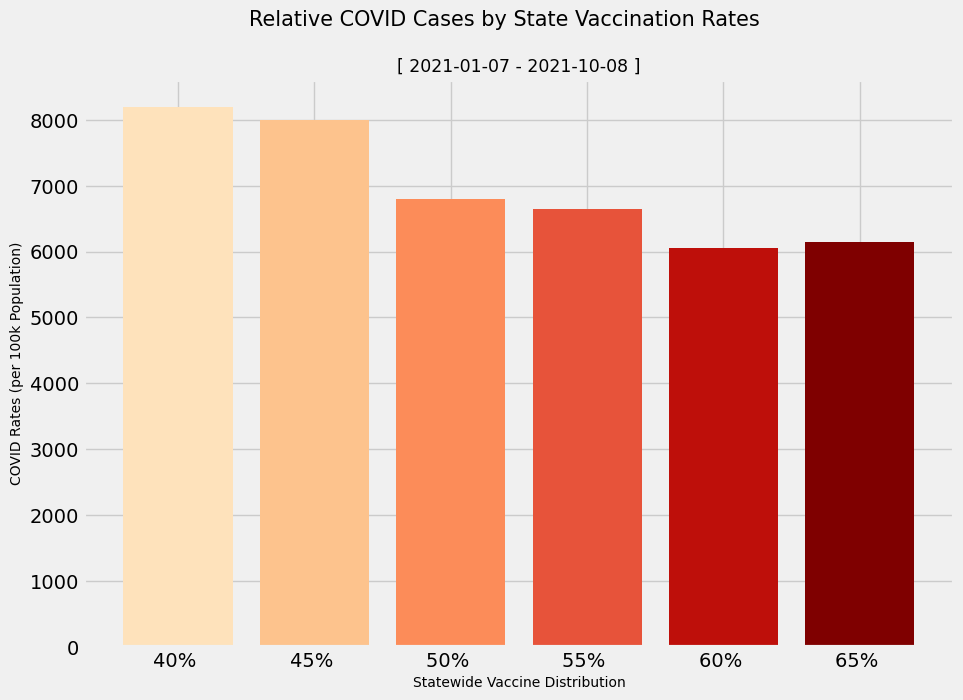

In [17]:


#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = overview_dict.keys()
y_vals = np.array([summer_overview_dict[x]['confirm_period_100k'] for x in summer_overview_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle('Relative COVID Cases by State Vaccination Rates',fontsize=fontsize*1.5)
plt.title(f'[ {start_summer_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("COVID Rates (per 100k Population)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_summer_covid_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_summer_covid_rates.jpg")

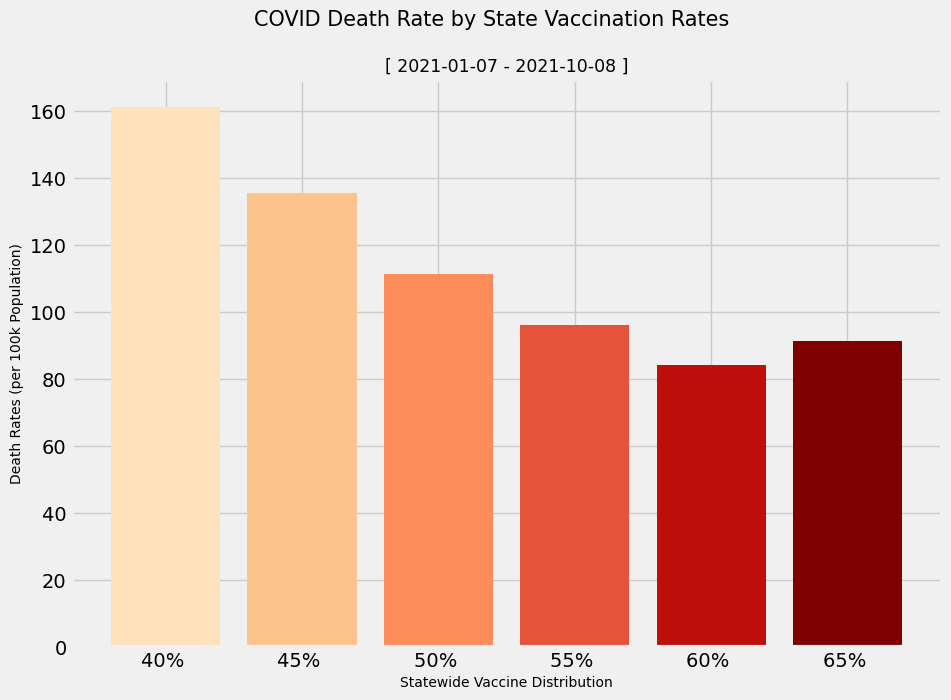

In [18]:
#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = overview_dict.keys()
y_vals = np.array([overview_dict[x]['death_period_100k'] for x in overview_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle('COVID Death Rate by State Vaccination Rates',fontsize=fontsize*1.5)
plt.title(f'[ {start_summer_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("Death Rates (per 100k Population)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_summer_death_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)


plt.show()
out_exec_summary_images.append("z_exec_summary_summer_death_rates.jpg")

['40% ', '45% ', '50% ', '55% ', '60% ', '65% ']


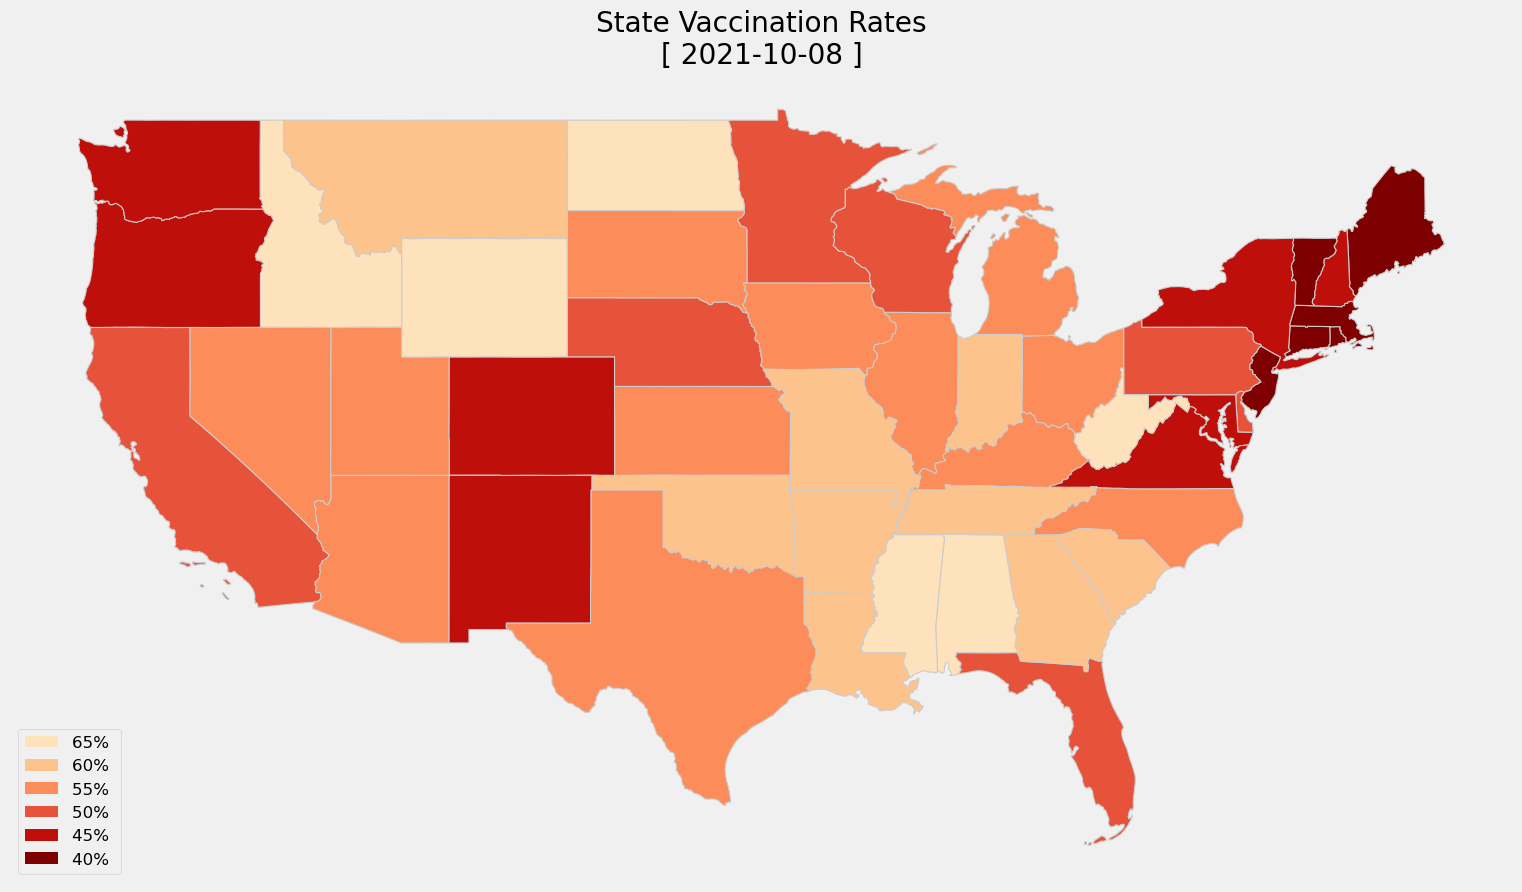

In [19]:
vax_dist_df = geo_vax_df[geo_vax_df['Date'] == geo_vax_df['Date'].max()].sort_values('Name')

td_state = []
td_tot = []

for key,value in overview_dict.items():
    for state in value['states']:
        td_state.append(state)
        td_tot.append(key)
tdf = pd.DataFrame([td_tot,td_state]).transpose()
tdf.columns = ['rank','Name']

vax_dist_df = vax_dist_df.merge(tdf,left_on='Name', right_on='Name')
vax_dist_df



#fig = plt.gcf()
#fig.set_size_inches(20,10)


labels=list(key_label_dict.values())
print(labels)

ax = vax_dist_df.plot(column='rank', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')
ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"State Vaccination Rates\n[ {end_date.date()} ]")
fig = plt.gcf()
fig.set_size_inches(20,10)

#//*** Handles is taken from earlie
plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)

outfilename='z_exec_summary_binned_vax_map.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()

In [20]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [21]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"



In [22]:
#attrib_death_df

In [23]:
#attrib_confirm_df[attrib_confirm_df.columns[:12]].iloc[:50].transpose()

#attrib_confirm_df[attrib_confirm_df['GEOID']== 40067]

In [24]:
#//*** Build Case attributes, if not using cached values
if not use_cached_files:

    #//*** Split Attribute Columns from Data Columns
    attrib_confirm_df = confirm_df[confirm_df.columns[:6]].copy()

    data_confirm_df = confirm_df[confirm_df.columns[6:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = data_confirm_df.columns[-2:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_confirm_df[col] = data_confirm_df[col]

        #//*** Delete Column from data_confirm_df
        del data_confirm_df[col]


    #//*** Split Death Columns into attrib_death_df and data_death_df
    attrib_death_df = death_df[death_df.columns[:7]].copy()

    data_death_df = death_df[death_df.columns[7:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = death_df.columns[-1:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_death_df[col] = data_death_df[col]

        #//*** Delete Column from data_confirm_df
        del data_death_df[col]



    #//*** Rename Attrib Columns for Cleanliness and Vanity
    ren_cols = {
        "POPESTIMATE" : "Population",
        "Combined_Key" : "Loc",
        "STNAME" : "State",
        "CTYNAME" : "County",
        #"9/17/21" : "New_Cases_9/17/21"
    }

    #//*** Get columns
    cols = np.array(attrib_confirm_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_confirm_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")

    #//**** Rename DEATH_DF Columns
    #//*** Get columns
    cols = np.array(attrib_death_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_death_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")
    attrib_death_df['Loc'] = attrib_death_df['Loc'].str.replace(", US","")


    #//*** Clean Attributes
    attrib_confirm_df

    #//**********************
    #//*** Build Daily Data
    #//**********************

    #//*** Get All Dates
    all_dates = list(data_confirm_df.columns)
    all_dates

    start_time = time.time()
    print(f"Begin Building Case Attributes...")


    #//*** Loop through each date and build daily derived Data
    for date in all_dates:

        #//*** Add New Cases for each Date
        col = f"{date}_New_Cases"
        attrib_confirm_df[col] = data_confirm_df[date].astype(int)
        
        col = f"{date}_New_Deaths"
        attrib_death_df[col]   = data_death_df[date].astype(int)

        #//*** Calculate New Cases Per 100k
        col = f"{date}_New_Cases_per_100k"
        attrib_confirm_df[col] = (data_confirm_df[date] / attrib_confirm_df['pop_100k']).astype(int)
        
        death_col = f"{date}_New_Deaths_per_100k"
        attrib_death_df[death_col] =   (data_death_df[date] / attrib_death_df['pop_100k']).astype(int)

        #//*** Build Scaled 100k cases (min=0, max=100)
        #//*** Make a copy to date_scaled_100k
        attrib_confirm_df[f"{date}_scaled_100k"] = attrib_confirm_df[col]
        attrib_death_df[f"{date}_scaled_100k"]   = attrib_death_df[death_col]


        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0

        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        #//*** Set Maximum community transmission to 100. This is the Max value on the CDC Scale, and it quiets this
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100

    #//*** Everything to a file
    attrib_confirm_df.to_pickle(attrib_confirm_filename)
    attrib_death_df.to_pickle(attrib_death_filename)


    # Writing to sample.json
    with open(all_dates_filename, "w") as outfile:
        outfile.write(json.dumps({"all_dates" : all_dates}))

print("Done!")

Done!


In [25]:
attrib_confirm_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                

<a id="build_casevax"></a> 
### Build Combined Case Death and Vaccination Data ###

In [26]:
#use_cached_files=False
if use_cached_files:
    print("Using Cached Combined Case, Death, Vaccination Data: Skip Processing")
else:
    #//**********************************************************************************
    #//*** Build combined County: Vaccination, Confirmed, Deaths table: casevax_df
    #//**********************************************************************************
    tdf = pd.read_pickle(county_vaccine_data_filename)
    tdf = tdf[['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes', 'Completeness_pct','Administered_Dose1_Recip','Administered_Dose1_Pop_Pct',]]

    #//*** Separate out the unknown County Values. We may do something with this later
    #unk_vax_df = tdf[tdf['FIPS'] == 'UNK'].copy()

    ##//*** Remove Unknowns
    tdf = tdf[tdf['FIPS'] != 'UNK']

    #//*** Convert to int for population attrib merge
    tdf['FIPS'] = tdf['FIPS'].astype(int)

    tdf['Date'] = tdf['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

    tdf = attrib_confirm_df[attrib_confirm_df.columns[:8]].merge(tdf, left_on="GEOID", right_on='FIPS').sort_values('Date',ascending=False).reset_index(drop='True')


    #//*** Convert New Cases From Columns to Rows.
    #//*** Use the GEOID to keep both Dataframes consistent
    #//*** Will build a new dataframe with these parts

    casevax_df = pd.DataFrame()
    i = 0
    #//*** For each GEOID (county)
    for group in tdf.groupby('GEOID'):
        #print(group[0],group[1]['NAME'].unique()[0])
        i+=1
        df_type = ""
        combine_df = group[1]
        for df in [attrib_death_df,attrib_confirm_df]:
            #//*** Grab attib_df county Values
            loop_df = df[df['GEOID']==group[0]] 
            #//*** Get columns with just New Cases
            cols = []
            for col in loop_df.columns:
                #//*** Handle New Cases Col
                if "New_Cases" in col and "100k" not in col:
                    cols.append(col)
                    df_type = "New_Cases"
                #//*** Handle New Deaths Col
                if "New_Deaths"  in col and "100k" not in col:
                    cols.append(col)
                    df_type = "New_Deaths"
            loop_df = loop_df[cols]

            #//*** Get just the dates from the columns
            cols = []
            for col in loop_df.columns:
                cols.append(col.split("_")[0])
            loop_df.columns = cols
            #//*** Transpose to convert columns to rows, reset_index to get a separate date column
            loop_df = loop_df.transpose().reset_index()


            #//*** reset column names
            if df_type == "New_Cases":
                loop_df.columns = ['Date','New_Cases']

            if df_type == "New_Deaths":
                loop_df.columns = ['Date','New_Deaths']


            loop_df['Date'] = loop_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
            
            

            combine_df = combine_df.merge(loop_df,left_on="Date", right_on="Date")
            


        combine_df = combine_df.sort_values('Date')

        #//*** Generate a 7 day average
        combine_df['case_7_day_avg'] = combine_df['New_Cases'].rolling(7).mean()

        combine_df['case_100k_avg'] = combine_df['case_7_day_avg'] / combine_df['pop_100k']

        combine_df['death_7_day_avg'] = combine_df['New_Deaths'].rolling(7).mean()

        combine_df['death_100k_avg'] = combine_df['death_7_day_avg'] / combine_df['pop_100k']


        #//*** Remove unneeded Columns
        for col in ["FIPS","Recip_County","Recip_State"]:
            if col in combine_df.columns:
                del combine_df[col]

        #//*** Drop the NaN values
        combine_df = combine_df.dropna()





        #//*** Merge then add to casevax_df
        casevax_df = pd.concat([casevax_df,combine_df])

    

        if i % 100 == 0:
            print(f"Working: {i} of {len(tdf['GEOID'].unique())}")
    casevax_df = casevax_df.sort_values(by=['Date','Province_State','NAME']).reset_index(drop=True)
    
    print("Saving to File.")
    casevax_df.to_pickle(casevax_filename)
    print("Done!")
    
    #casevax_df.corr()
    #print(pearsonr(casevax_df["New_Cases"],casevax_df["case_7_day_avg"]))
    #print(pearsonr(casevax_df["Administered_Dose1_Recip"],casevax_df["case_7_day_avg"]))
    #print(pearsonr(casevax_df["Series_Complete_Yes"],casevax_df["New_Cases"]))


    #casevax_df.iloc[-30:]

Using Cached Combined Case, Death, Vaccination Data: Skip Processing


In [27]:
attrib_confirm_df[attrib_confirm_df['NAME']=="Kern"]

STATEFP  GEOID  NAME                                           geometry Province_State               Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
1114      06   6029  Kern  POLYGON ((-120.19415 35.78920, -119.53812 35.7...     California  Kern, California      900202   9.00202                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
1114                    0                  0                           0                    0                  0                           0                    0                 0   

      2/1/20_New_Cases_per_100k  2/1/20_scaled_100k  2/2/20_New_Cases  2/2/20_New_Cases_per_100k  2/2/20_scaled_100k  2/3/20_New_Cases  2/3/20_New_Cases_per_100k  2/3/20_scaled_100k  \
1114                          0                   0                 0                          0                   0                 0                          0                   0   

      2/4/20_New_Cases  2/4/20_New_Cases_per_100k  2/4/20_scaled_100k  2/5/20_New_Cases  2/5/20_New_Cases_per_100k  2/5/20_scaled_100k  2/6/20_New_Cases  2/6/20_New_Cases_per_100k  \
1114                 0                          0                   0                 0                          0                   0                 0                          0   

      2/6/20_scaled_100k  2/7/20_New_Cases  2/7/20_New_Cases_per_100k  2/7/20_scaled_100k  2/8/20_New_Cases  2/8/20_New_Cases_per_100k  2/8/20_scaled_100k  2/9/20_New_Cases  \
1114                   0                 0                          0                   0                 0                          0                   0                 0   

      2/9/20_New_Cases_per_100k  2/9/20_scaled_100k  2/10/20_New_Cases  2/10/20_New_Cases_per_100k  2/10/20_scaled_100k  2/11/20_New_Cases  2/11/20_New_Cases_per_100k  2/11/20_scaled_100k  \
1114                          0                   0                  0                           0                    0                  0                           0                    0   

      2/12/20_New_Cases  2/12/20_New_Cases_per_100k  2/12/20_scaled_100k  2/13/20_New_Cases  2/13/20_New_Cases_per_100k  2/13/20_scaled_100k  2/14/20_New_Cases  2/14/20_New_Cases_per_100k  \
1114                  0                           0                    0                  0                           0                    0                  0                           0   

      2/14/20_scaled_100k  2/15/20_New_Cases  2/15/20_New_Cases_per_100k  2/15/20_scaled_100k  2/16/20_New_Cases  2/16/20_New_Cases_per_100k  2/16/20_scaled_100k  2/17/20_New_Cases  \
1114                    0                  0                           0                    0                  0                           0                    0                  0   

      2/17/20_New_Cases_per_100k  2/17/20_scaled_100k  2/18/20_New_Cases  2/18/20_New_Cases_per_100k  2/18/20_scaled_100k  2/19/20_New_Cases  2/19/20_New_Cases_per_100k  2/19/20_scaled_100k  \
1114                           0                    0                  0                           0                    0                  0                           0                    0   

      2/20/20_New_Cases  2/20/20_New_Cases_per_100k  2/20/20_scaled_100k  2/21/20_New_Cases  2/21/20_New_Cases_per_100k  2/21/20_scaled_100k  2/22/20_New_Cases  2/22/20_New_Cases_per_100k  \
1114                  0                           0                    0                  0                           0                    0                  0                           0   

      2/22/20_scaled_100k  2/23/20_New_Cases  2/23/20_New_Cases_per_100k  2/23/20_scaled_100k  2/24/20_New_Cases  2/24/20_New_Cases_per_100k  2/24/20_scaled_100k  2/25/20_New_Cases  \
1114                    0                  0                           0                    0

In [28]:
casevax_df

STATEFP  GEOID        NAME                                           geometry Province_State                  Loc  Population  pop_100k       Date  Series_Complete_Pop_Pct  \
0           01   1001     Autauga  POLYGON ((-86.91759 32.66417, -86.71339 32.661...        Alabama     Autauga, Alabama       55869   0.55869 2020-12-19                      0.0   
1           01   1003     Baldwin  POLYGON ((-88.02632 30.75336, -87.94455 30.827...        Alabama     Baldwin, Alabama      223234   2.23234 2020-12-19                      0.0   
2           01   1005     Barbour  POLYGON ((-85.73573 31.62449, -85.66565 31.786...        Alabama     Barbour, Alabama       24686   0.24686 2020-12-19                      0.0   
3           01   1007        Bibb  POLYGON ((-87.42194 33.00338, -87.31854 33.006...        Alabama        Bibb, Alabama       22394   0.22394 2020-12-19                      0.0   
4           01   1009      Blount  POLYGON ((-86.96336 33.85822, -86.92439 33.909...        Alabama      Blount, Alabama       57826   0.57826 2020-12-19                      0.0   
...        ...    ...         ...                                                ...            ...                  ...         ...       ...        ...                      ...   
883425      56  56037  Sweetwater  POLYGON ((-110.05371 42.27074, -109.49676 42.2...        Wyoming  Sweetwater, Wyoming       42343   0.42343 2021-10-08                     37.5   
883426      56  56039       Teton  POLYGON ((-111.05533 44.66626, -110.66787 44.6...        Wyoming       Teton, Wyoming       23464   0.23464 2021-10-08                     79.7   
883427      56  56041       Uinta  POLYGON ((-111.04664 41.25163, -111.04660 41.3...        Wyoming       Uinta, Wyoming       20226   0.20226 2021-10-08                     40.1   
883428      56  56043    Washakie  POLYGON ((-108.55056 44.16845, -107.54120 44.1...        Wyoming    Washakie, Wyoming        7805   0.07805 2021-10-08                     35.7   
883429      56  56045      Weston  POLYGON ((-105.07928 44.17618, -104.37548 44.1...        Wyoming      Weston, Wyoming        6927   0.06927 2021-10-08                     31.0   

        Series_Complete_Yes  Completeness_pct  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  New_Deaths  New_Cases  case_7_day_avg  case_100k_avg  death_7_day_avg  death_100k_avg  
0                         0               0.0                       0.0                         0.0           0         62       51.571429      92.307771         0.000000        0.000000  
1                         0               0.0                       0.0                         0.0           0        151      154.000000      68.985907         0.000000        0.000000  
2                         0               0.0                       0.0                         0.0           0          8        7.142857      28.934850         0.000000        0.000000  
3                         0               0.0                       0.0                         0.0           0         26       25.000000     111.637046         0.000000        0.000000  
4                         0               0.0                       0.0                         0.0           1         63       65.000000     112.406184         0.142857        0.247047  
...                     ...               ...                       ...                         ...         ...        ...             ...            ...              ...             ...  
883425                15863              96.4                   19654.0                        46.4           0         26       28.428571      67.138775         0.000000        0.000000  
883426                18693              96.4                   21072.0                        89.8           0          5        5.857143      24.962252         0.000000        0.000000  
883427                 8115              96.4                    9510.0                        47.0           0         1

2020-12-25 00:00:00


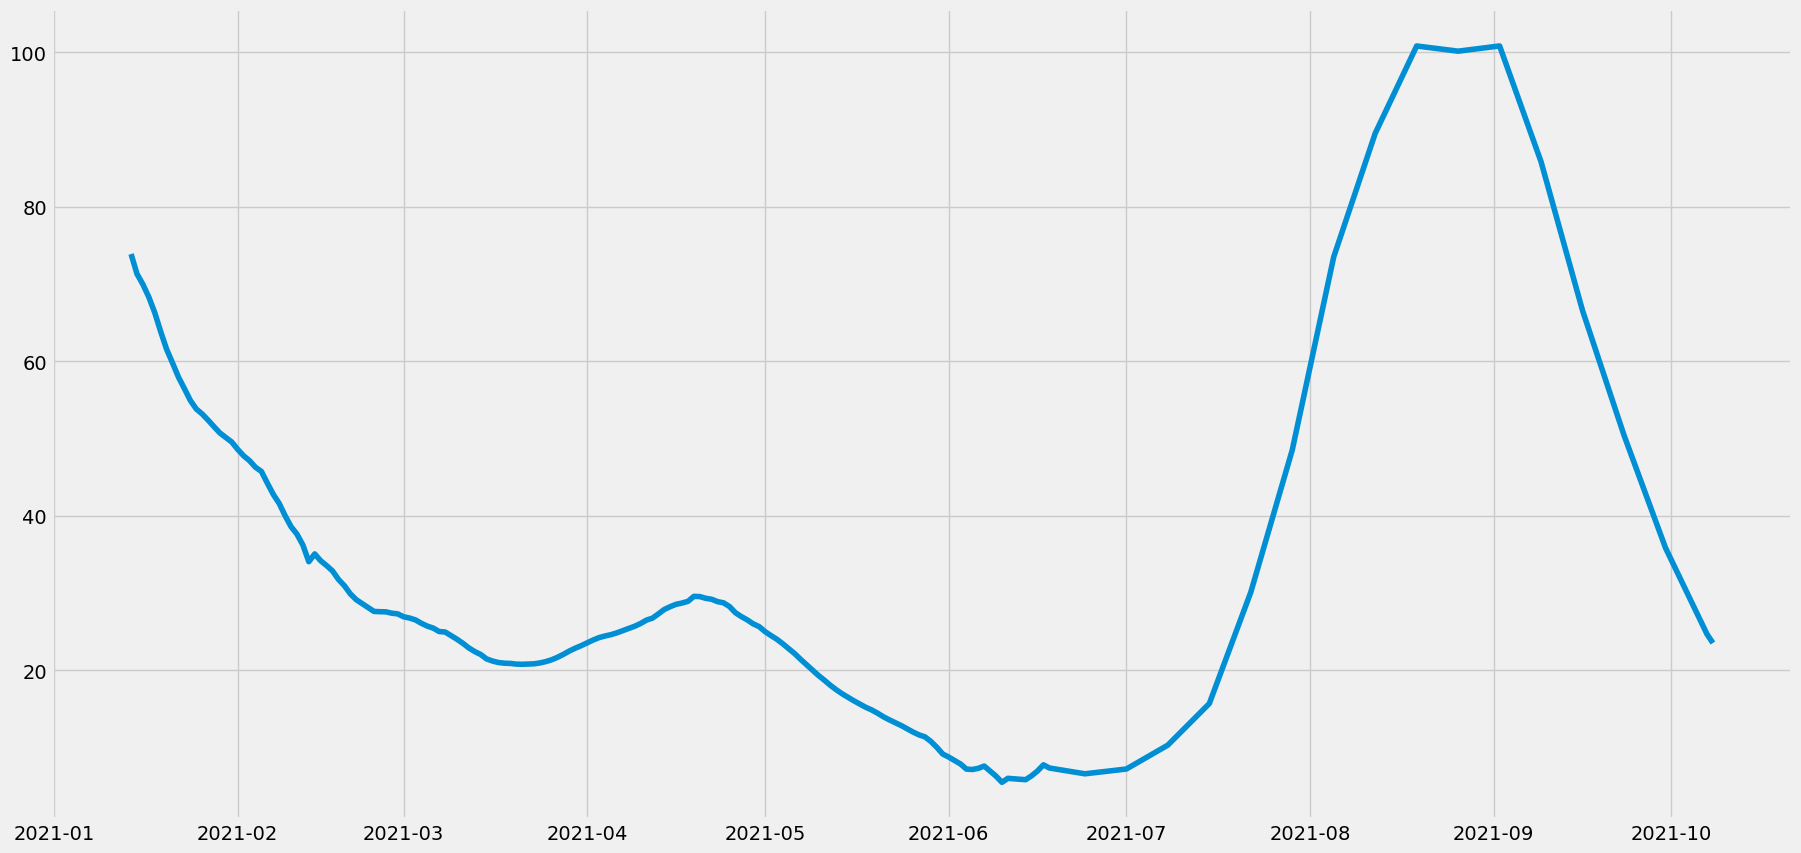

Length:  268
Date              2021-09-24 00:00:00
Complete_pct                55.862971
case_7_day_avg                10382.0
Name: 279, dtype: object
Score: 0.684958633089557
intercept: -51.15817811589659
slope: [55.2783622   0.75532019]


In [29]:
#Mask Mandates Ended June 15th

#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_California
#https://en.wikipedia.org/wiki/California_government_response_to_the_COVID-19_pandemic#June_2



ca_df = pd.DataFrame()

cols = ['Date','Province_State','Population','Series_Complete_Yes','Administered_Dose1_Recip','New_Cases','New_Deaths']
for group in casevax_df[casevax_df['Province_State'] == 'Florida'].sort_values("Date").groupby('Date'):
    #//*** Sum Values for Reporting Counties
    tl = [group[0],'California']
    for col in cols:
        if col == 'Date':
            continue
        if col == 'Province_State':
            continue
            
        tl.append(group[1][col].sum())
    ca_df = ca_df.append(pd.Series(tl,index=cols),ignore_index=True)
    
    
ca_df['Complete_pct'] = (ca_df['Series_Complete_Yes'] / ca_df['Population']) * 100
ca_df['Dose1_pct'] = (ca_df['Administered_Dose1_Recip'] / ca_df['Population']) * 100

ca_df['case_7_day_avg'] = ca_df['New_Cases'].rolling(7).mean()
ca_df['death_7_day_avg'] = ca_df['New_Deaths'].rolling(7).mean()

ca_df['case_100k_avg'] = ca_df['case_7_day_avg'] / (ca_df['Population'] / 100000)
ca_df['death_100k_avg'] = ca_df['death_7_day_avg'] / (ca_df['Population'] / 100000)
ca_df = ca_df.dropna()

print(ca_df['Date'].iloc[0])



loop_df = ca_df.copy()
loop_df = loop_df[loop_df['Date'] > datetime(year=2021,month=1,day=13)]
#loop_df = loop_df[loop_df['Date'] < datetime.datetime(year=2021,month=7,day=1)]


fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)


ax.plot(loop_df['Date'],loop_df['case_100k_avg']    )
#plt.title("Household Expenditures: 1984-2008",fontsize=30)
#plt.legend()
#plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
#ax.set_ylabel("Expenses ($)",fontsize=15)
#ax.tick_params(axis='both', labelsize=12)

plt.show()

print("Length: ",len(loop_df))

#ca_df = ca_df[ca_df['Administered_Dose1_Pop_Pct'] < 20]
offset = 14
last_df = loop_df.iloc[offset*-1:]

x_fields = ['Complete_pct','case_7_day_avg']
offset_field = "case_7_day_avg"


l = list(loop_df[offset_field])[offset:]
for x in range(offset):
    l.append(np.nan)
#print(len(loop_df),len(l),(len(loop_df)-len(l)))

loop_df['offset_1st_offset'] = l
loop_df = loop_df.dropna()




model_df = loop_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[x_fields]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(loop_df[['Date','Complete_pct',f'{offset_field}']].iloc[-1])
print('Score:',regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)




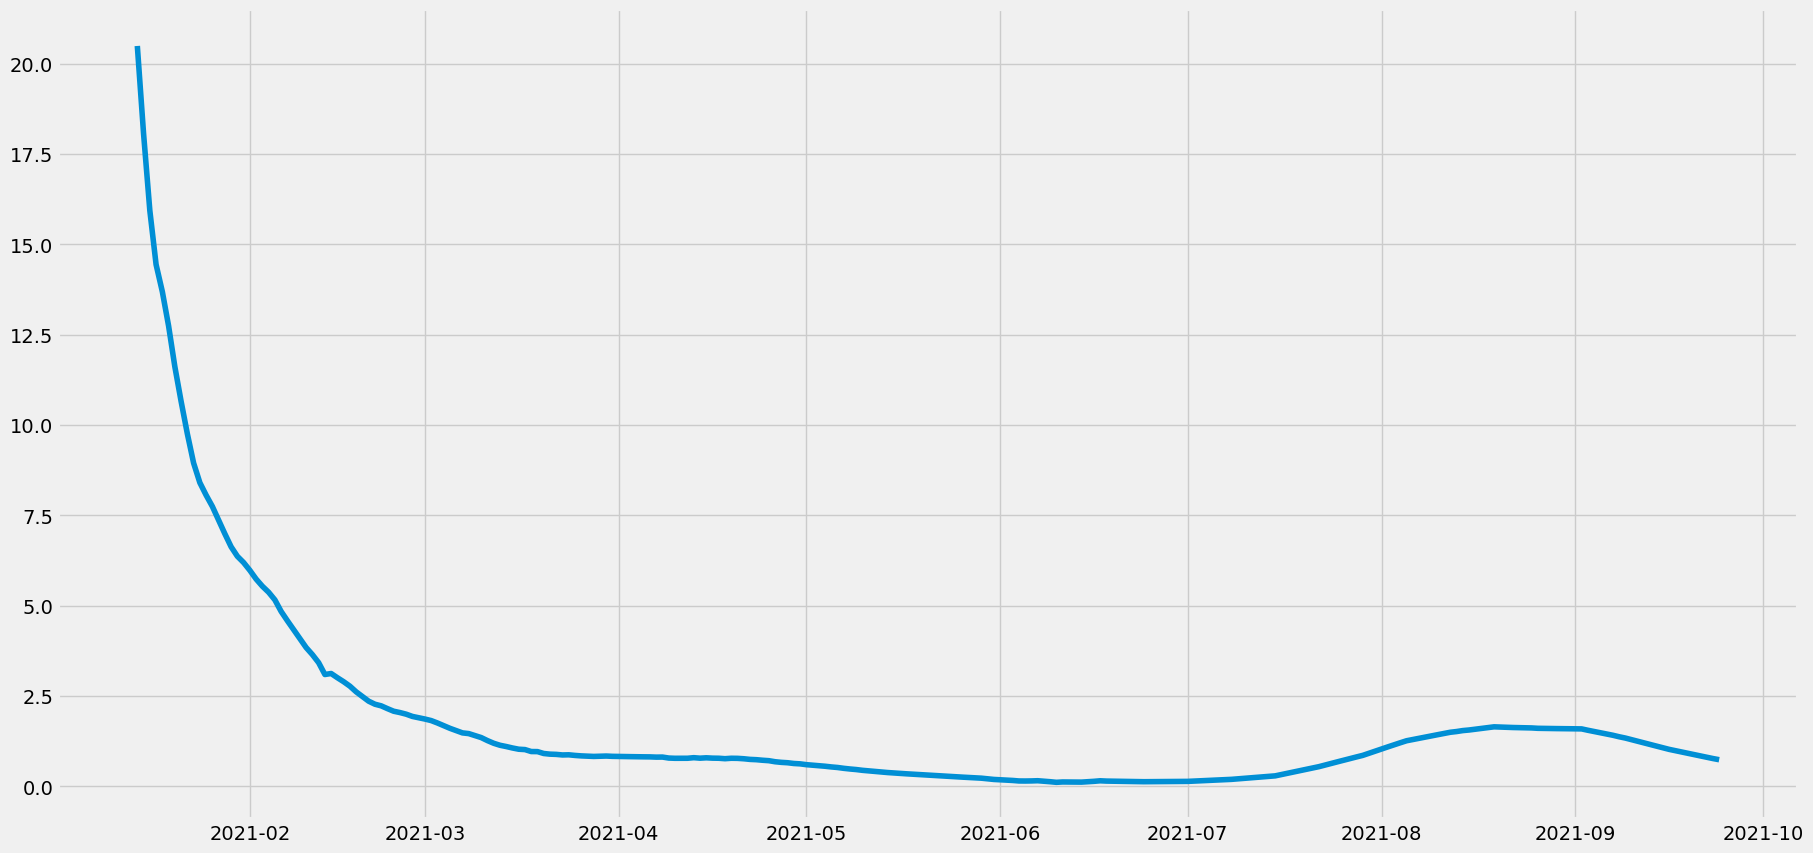

In [30]:
ca_df['Dose1_pct']/ca_df['case_100k_avg']



fig, ax = plt.subplots()
fig = plt.gcf()
fig.set_size_inches(20,10)


ax.plot(loop_df['Date'],loop_df['case_100k_avg'] / loop_df['Dose1_pct']  )
#plt.title("Household Expenditures: 1984-2008",fontsize=30)
#plt.legend()
#plt.legend(reversed(plt.legend().legendHandles), reversed(plot_dict.keys()),loc='upper left')
#ax.set_ylabel("Expenses ($)",fontsize=15)
#ax.tick_params(axis='both', labelsize=12)

plt.show()

In [31]:


#casevax_df[casevax_df['Date'] == casevax_df['Date'].unique()[-1]].sort_values("Series_Complete_Pop_Pct")

la_df = casevax_df[casevax_df['Province_State'] == 'California'].sort_values("Date")
print(la_df['Administered_Dose1_Pop_Pct'].max())
print(la_df)
#la_df = la_df[["Date","Administered_Dose1_Pop_Pct","case_7_day_avg","death_7_day_avg"]]

la_df = la_df[la_df['Administered_Dose1_Pop_Pct'] > 40]
#la_df = la_df[la_df['Administered_Dose1_Pop_Pct'] < 20]
offset = 14
last_df = la_df.iloc[offset*-1:]

#for offset in range(1,14):

l = list(la_df["case_100k_avg"])[offset:]
for x in range(offset):
    l.append(np.nan)
#print(len(la_df),len(l),(len(la_df)-len(l)))

la_df[f'offset_1st_offset'] = l
la_df = la_df.dropna()

la_df

model_df = la_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[['Administered_Dose1_Pop_Pct']]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

#print(regr.predict(x_model))
la_df
#geo_vax_df

99.9
       STATEFP  GEOID        NAME                                           geometry Province_State                     Loc  Population  pop_100k       Date  Series_Complete_Pop_Pct  \
157         06   6001     Alameda  POLYGON ((-122.33371 37.80980, -122.30393 37.8...     California     Alameda, California     1671329  16.71329 2020-12-19                      0.0   
188         06   6063      Plumas  POLYGON ((-121.49764 40.44559, -121.36146 40.4...     California      Plumas, California       18807   0.18807 2020-12-19                      0.0   
189         06   6065   Riverside  POLYGON ((-117.67313 33.87100, -117.65537 33.9...     California   Riverside, California     2470546  24.70546 2020-12-19                      0.0   
190         06   6067  Sacramento  POLYGON ((-121.86246 38.06603, -121.71213 38.0...     California  Sacramento, California     1552058  15.52058 2020-12-19                      0.0   
191         06   6069  San Benito  POLYGON ((-121.64400 36.89400, -121

STATEFP  GEOID          NAME                                           geometry Province_State                       Loc  Population  pop_100k       Date  Series_Complete_Pop_Pct  \
298334      06   6041         Marin  POLYGON ((-123.01153 38.00344, -122.96089 38.1...     California         Marin, California      258826   2.58826 2021-03-25                     23.1   
301423      06   6041         Marin  POLYGON ((-123.01153 38.00344, -122.96089 38.1...     California         Marin, California      258826   2.58826 2021-03-26                     24.3   
304513      06   6041         Marin  POLYGON ((-123.01153 38.00344, -122.96089 38.1...     California         Marin, California      258826   2.58826 2021-03-27                     25.2   
307602      06   6041         Marin  POLYGON ((-123.01153 38.00344, -122.96089 38.1...     California         Marin, California      258826   2.58826 2021-03-28                     26.1   
310691      06   6041         Marin  POLYGON ((-123.01153 38.00344, -122.96089 38.1...     California         Marin, California      258826   2.58826 2021-03-29                     26.9   
...        ...    ...           ...                                                ...            ...                       ...         ...       ...        ...                      ...   
880605      06   6007         Butte  POLYGON ((-122.04487 39.88377, -121.80404 39.8...     California         Butte, California      219186   2.19186 2021-10-08                     46.0   
880606      06   6009     Calaveras  POLYGON ((-120.99550 38.22540, -120.89286 38.2...     California     Calaveras, California       45905   0.45905 2021-10-08                     52.3   
880607      06   6011        Colusa  POLYGON ((-122.78509 39.38297, -122.73906 39.3...     California        Colusa, California       21547   0.21547 2021-10-08                     50.1   
880608      06   6013  Contra Costa  POLYGON ((-122.42526 37.95567, -122.36758 37.9...     California  Contra Costa, California     1153526  11.53526 2021-10-08                     69.8   
880609      06   6015     Del Norte  POLYGON ((-124.21959 41.84643, -124.20340 41.9...     California     Del Norte, California       27812   0.27812 2021-10-08                     36.0   

        Series_Complete_Yes  Completeness_pct  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  New_Deaths  New_Cases  case_7_day_avg  case_100k_avg  death_7_day_avg  death_100k_avg  \
298334                59914              96.8                  105100.0                        40.6           0         16       13.571429       5.243456         0.000000        0.000000   
301423                62856              96.8                  107063.0                        41.4           0         17       14.571429       5.629816         0.000000        0.000000   
304513                65141              96.8                  109502.0                        42.3           0         18       15.428571       5.960982         0.000000        0.000000   
307602                67621              96.9                  111504.0                        43.1           0         16       15.714286       6.071371         0.000000        0.000000   
310691                69658              96.9                  113698.0                        43.9           0         16       16.000000       6.181759         0.000000        0.000000   
...                     ...               ...                       ...                         ...         ...        ...             ...            ...              ...             ...   
880605               100902              97.4                  114615.0                        52.3           1         63       79.714286      36.368329         0.571429        0.260705   
880606                24006              97.4                   32040.0                        69.8           0         18       17.428571      37.966608         0.000000        0.000000   
880607                10796 

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression
model_df = la_df
#//*** Build the X attributes using the x_column. These are separated for readability and modularity
x_model = model_df[['Administered_Dose1_Pop_Pct','case_100k_avg']]
y_model = model_df['offset_1st_offset']
#//*** Define the Linear Model
regr = LinearRegression(n_jobs=-1,positive=True)

#//*** Make Regression Magic
regr.fit(x_model, y_model)

print(regr.score(x_model, y_model))
print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

#print(regr.predict(x_model))
regr.get_params()

0.4840845208070257
intercept: -21.802368783173904
slope: [0.50263247 0.62913498]


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -1,
 'normalize': False,
 'positive': True}

In [33]:
"""
race_columns = (pop_attrib_df[['county',race]].sort_values(race,ascending=False)['county'])

        #print(model_df[race_columns])
        #//*** Build the X attributes using the x_column. These are separated for readability and modularity
        x_model = model_df[race_columns]

        #print(x_model)
        #//*** Build the independent variable using the Index Column defined above as y_col_index.
        y_column = model_df.columns[y_col_index]

        #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
        #//*** easily assigned at the top of this section
        y_model = model_df[y_column]

        #//*** Define the Linear Model
        regr = linear_model.LinearRegression(n_jobs=-1)

        #//*** Make Regression Magic
        regr.fit(x_model, y_model)

        #//*** Apply the regression coefficients
        #//*** v1 Change: Apply coef to actual values
        model_df[race_columns] = (model_df[race_columns])*regr.coef_
        
        
        #//*** Dead End: v2 Change: Try just the coefficients 
        #model_df[race_columns] = regr.coef_



        #//*** Replace the Statewide Total Column. With the Statewide Race Totals
        model_df['total'] = model_df[race]

        #//*** Change The race column to hold the race name
        model_df[race] = race

        #//*** Rename the race (Latino, Native, etc) to 'race'
        cols = list(model_df.columns)
        cols[1] = 'race'
        model_df.columns = cols

        model_df['intercept'] = regr.intercept_
"""
print()

In [34]:
geo_vax_df

STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
298        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
297        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
296        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
295        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
294        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-18       AL                 0             0.0                       0   
..       ...    ...      ...                                                ...      ...         ...   ...        ...      ...               ...             ...                     ...   
4         56     56  Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...  Wyoming          WY    56 2021-10-04       WY            281079            48.6                  241117   
3         56     56  Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...  Wyoming          WY    56 2021-10-05       WY            282983            48.9                  243192   
2         56     56  Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...  Wyoming          WY    56 2021-10-06       WY            283442            49.0                  243711   
1         56     56  Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...  Wyoming          WY    56 2021-10-07       WY            283932            49.1                  244243   
0         56     56  Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...  Wyoming          WY    56 2021-10-08       WY            284600            49.2                  244957   

     total_vaccinated_percent    state population tot_death tot_confirm New_Cases  case_7_day_avg case_avg_100k New_Deaths  death_7_day_avg death_avg_100k  
298                       0.0  Alabama    4903185      4102      297895      5054     7345.714286    103.075858          0        60.428571            0.0  
297                       0.0  Alabama    4903185      4124      301533      5902     7219.142857    120.370739         22        56.000000       0.448688  
296                       0.0  Alabama    4903185      4198      305640      7745     7188.714286    157.958551         96        56.428571       1.957911  
295                       0.0  Alabama    4903185      4254      310335      8802     7266.571429    179.515968        130        61.857143       2.651338  
294                       0.0  Alabama    4903185      4296      315683     10043     7474.428571    204.826047         98        61.428571       1.998701  
..                        ...      ...        ...       ...         ...       ...             ...           ...        ...              ...            ...  
4                        41.7  Wyoming     578759       996       91979       810      906.714286    139.954627          0        11.714286            0.0  
3                        42.0  Wyoming     578759      1041       92415      1246      861.285714    215.288229         45        12.285714       7.775257  
2                        42.1  Wyoming     578759      1041       93083      1104      871.857143    190.752973         45        12.857143       7.775257  
1                        42.2  Wyoming     578759      1041       93764      1349      897.142857    233.084928          0        12.857143            0.0  
0                    

In [35]:

#//********************************************
#//*** Build Current Vaccine Stats
#//********************************************

plot_df = geo_vax_df[geo_vax_df['Date'] == geo_vax_df['Date'].max()]

ren_cols = {
    "total_vaccinated_percent" : "Fully Vaccinated %",
    "first_dose_pct" : "Partially Vaccinated %"
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

    
category = "Fully Vaccinated %"

hover_cols = (["Name","Fully Vaccinated %","Partially Vaccinated %"] )
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID Vaccinations\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    simplify_shapes=50,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Blues",
    colormap="Cividis",
    hovertool_columns=hover_cols,
    toolbar_location=None,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['vaccine_us_current'] = out_html

In [36]:
from bokeh.models import ColumnDataSource
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
plot_df = vax_df[-30:].copy()
plot_df['Series_Complete_Yes'] = plot_df['Series_Complete_Yes'] / 1000000
plot_df['Administered_Dose1_Recip'] = plot_df['Administered_Dose1_Recip'] / 1000000
plot_df['datelabel'] = plot_df['Date'].dt.strftime("%m/%d")

#plot_df['Series_Complete_Pop_Pct'] = plot_df['Series_Complete_Pop_Pct'].astype(str) + "%"
#plot_df['range']= np.arange(len(plot_df))

ren_cols = {
    "Series_Complete_Pop_Pct" : "Fully_Vaccinated",
    "Administered_Dose1_Pop_Pct" : "Partially_Vaccinated",
    "Series_Complete_Yes" : "Vaccinated",
    "Administered_Dose1_Recip" : "First_Dose",
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="U.S. Fully Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Fully_Vaccinated',x='Date',source=plot_df,legend_label="Fully Vaccinated")
p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['vax_full_30day'] = f"{div}\n {script}"
 
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="Partially_Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Partially_Vaccinated',x='Date',color='orange',source=plot_df,legend_label="First Dose")
p.scatter(y='Partially_Vaccinated',x='Date',source=plot_df,color='orange')
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['vax_partial_30day'] = f"{div}\n {script}"




In [37]:
death_df = pd.read_csv(death_data_filename)

death_df

death_df['Province_State'].unique()
death_df = death_df[death_df['iso2'] =='US']
death_df = death_df[death_df['Province_State'] != "Diamond Princess"]
death_df = death_df[death_df['Province_State'] != "Grand Princess"]


cols = []

cols.append(death_df.columns[6])
cols.append(death_df.columns[11])
cols = cols+list(death_df.columns[-37:])

death_state_df = pd.DataFrame(columns=cols)

for group in death_df.groupby("Province_State"):
    
   
    tds = group[1][ cols ].sum()
    tds['Province_State'] = group[0]
    #death_state_df=pd.concat([death_state_df,tds],axis=1)
    death_state_df.loc[len(death_state_df.index)] = tds
    
#death_state_df = death_state_df.transpose().reset_index(drop=True)

#death_state_df = death_state_df[ [death_state_df.columns[0]] + list(death_state_df.columns[-30:]) ] 

#//*** Generate New Deaths per Day 7-day average
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].rolling(7,axis=1).mean()


pop100k = death_state_df['Population'] / 1000000

#for col in death_state_df[death_state_df.columns[2:]]:
#    death_state_df[col] = death_state_df[col] / pop100k

death_state_df = death_state_df.dropna(axis=1)

for col in death_state_df[death_state_df.columns[2:]]:
    death_state_df[col] = death_state_df[col].astype(str)
    death_state_df[col] = death_state_df[col].apply(lambda x : x[:4])
    death_state_df[col] = death_state_df[col].astype(float)

#death_state_df = death_state_df.sort_values(death_state_df.columns[-1],ascending=False)
total_us_deaths = death_state_df[death_state_df.columns[2:]].sum()
#plot_df = death_state_df.iloc[:10].reset_index(drop=True)
#plot_df

death_state_df
plot_df = death_state_df[death_state_df.columns[:2]].copy()
plot_df[death_state_df.columns[-1]] = death_state_df[death_state_df.columns[-1]]
plot_df.columns = ["State","Population","100k"]
plot_df["100k"] = plot_df["100k"] / pop100k
plot_df["100k"] = plot_df["100k"].apply(np.floor)
plot_df = plot_df.sort_values("100k",ascending=True)

date = death_state_df.columns[-1]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)

#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['State'])
# create a new plot (with a title) using figure
p = figure(plot_width=int(med_figsize_x*.8), 
           plot_height=med_figsize_y*2,
           y_range=labels,
           title=f"Statewide New Deaths (per 100k) 7 - Day Avg\nUpdated: {date}",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Deaths / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_deaths'] = f"{div}\n {script}"

In [38]:
plot_df

State Population 100k
6            Connecticut    3565287    0
27              Nebraska    1934408    0
32              New York   19453561    1
8   District of Columbia     705749    1
29         New Hampshire    1359711    1
44                  Utah    3205958    2
1                 Alaska     740995    2
39          Rhode Island    1059361    2
4             California   39512223    2
30            New Jersey    8882190    2
49             Wisconsin    5822434    2
13              Illinois   12671821    2
21         Massachusetts    6892503    2
20              Maryland    6045680    2
31            New Mexico    2096829    3
23             Minnesota    5639632    3
25              Missouri    6626371    3
22              Michigan    9986857    3
5               Colorado    5758736    3
45               Vermont     623989    3
35                  Ohio   11689100    4
47            Washington    7614893    4
3               Arkansas    3017804    4
11                Hawaii    1415872    4
41          South Dakota     884659    4
15                  Iowa    3155070    4
19                 Maine    1344212    4
46              Virginia    8535519    4
34          North Dakota     762062    4
38          Pennsylvania   12801989    5
2                Arizona    7278717    5
37                Oregon    4217737    5
28                Nevada    3080156    5
18             Louisiana    4648794    5
7               Delaware     973764    6
14               Indiana    6732219    6
33        North Carolina   10488084    6
24           Mississippi    2976149    7
43                 Texas   28995881    7
42             Tennessee    6829174    7
17              Kentucky    4467673    7
26               Montana    1068778    8
9                Florida   21477737    9
36              Oklahoma    3956971    9
40        South Carolina    5148714    9
0                Alabama    4903185   10
50               Wyoming     578759   11
10               Georgia   10617423   12
12                 Idaho    1787065   14
48         West Virginia    1792147   16
16                Kansas    2913314   20

In [39]:
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

plot_df = pd.DataFrame()
plot_df['DateString'] = total_us_deaths.index
plot_df['Date'] = plot_df['DateString'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
plot_df['Deaths'] = total_us_deaths.values
plot_df['index'] = np.arange(len(total_us_deaths))
plot_df = ColumnDataSource(plot_df)


x = np.arange(len(total_us_deaths))
# create a new plot
p = figure(plot_width=med_figsize_x, 
           plot_height=med_figsize_y, 
           title="U.S. New Deaths Per Day (7-Day Avg)",
           toolbar_location=None,
           tools='hover',
           tooltips =[    
               ( "Date",  "@DateString" ),
               ("Value", "$y{0} / Day"),
           ]
          )


#print(thisRow)
p.line(x="Date", y="Deaths", source=plot_df, alpha=0.8, color='black', line_width=2)
p.circle(x="Date", y="Deaths", source=plot_df, size=10, color='red',alpha=0.5)

p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "Daily Deaths"
#p.legend.location = "bottom_right"

show(p)

script, div = components(p)
out_plot['us_new_deaths'] = f"{div}\n {script}"

In [40]:
death_state_df

Province_State Population  9/9/21  9/10/21  9/11/21  9/12/21  9/13/21  9/14/21  9/15/21  9/16/21  9/17/21  9/18/21  9/19/21  9/20/21  9/21/21  9/22/21  9/23/21  9/24/21  9/25/21  9/26/21  \
0                Alabama    4903185   31.70    30.10    37.00    37.20    37.40    42.50    42.20    43.40    63.20    76.50    76.20    76.00   106.00   125.00   134.00   124.00   116.00   116.00   
1                 Alaska     740995    1.14     1.42     1.42     1.42     1.57     2.28     1.71     1.71     1.57     1.57     1.57     2.14     2.00     1.85     2.85     9.00     9.00     9.00   
2                Arizona    7278717   37.40    26.80    26.50    27.00    26.80    35.80    36.20    31.20    33.10    43.40    46.50    46.50    40.00    46.40    52.40    51.10    45.50    42.70   
3               Arkansas    3017804   23.70    25.20    27.70    30.00    32.50    32.20    31.40    32.20    30.40    28.80    25.40    26.20    23.50    23.70    21.80    21.20    20.10    20.70   
4             California   39512223   87.20    96.80    97.00    90.20   104.00   108.00   119.00   125.00   115.00   117.00   123.00   114.00   113.00   108.00   102.00   110.00   101.00    91.00   
5               Colorado    5758736   12.00    11.40    11.40    11.40    11.00    13.40    14.80    13.50    14.20    14.20    14.20    14.70    15.40    13.50    15.20    14.00    14.00    14.00   
6            Connecticut    3565287    3.14     4.28     4.28     4.28     4.28     7.28     4.57     4.42     5.57     5.57     5.57     5.42     4.42     5.28     5.14     5.42     5.42     5.42   
7               Delaware     973764    1.71     1.71     1.28     1.28     1.28     1.57     2.42     1.85     1.85     2.85     2.85     2.85     3.57     2.57     4.14     4.14     3.14     3.14   
8   District of Columbia     705749    0.42     0.42     0.42     0.42     0.42     0.57     0.57     0.42     0.28     0.28     0.28     0.71     0.57     0.57     0.71     0.71     0.71     0.71   
9                Florida   21477737  337.00   349.00   349.00   349.00   418.00   325.00   325.00   362.00   352.00   352.00   352.00   376.00   376.00   376.00   327.00   334.00   334.00   334.00   
10               Georgia   10617423   82.70    88.70    88.70    88.70   111.00    98.00   124.00   125.00   119.00   119.00   119.00   124.00   131.00   124.00   125.00   128.00   128.00   128.00   
11                Hawaii    1415872    3.85     4.00     5.57     5.14     4.85     4.85     6.42     6.57     7.57     7.00     7.71     7.71     7.71     7.85     8.42     7.57     6.42     6.14   
12                 Idaho    1787065    9.71    11.50    13.20    13.20    15.10    13.70    19.10    21.80    21.80    23.40    23.40    23.40    22.40    18.10    17.00    20.00    16.70    16.70   
13              Illinois   12671821   26.40    27.70    27.70    27.70    42.80    39.10    36.70    39.50    40.70    40.70    40.70    38.80    36.20    35.40    35.80    33.80    33.80    33.80   
14               Indiana    6732219   30.50    30.40    30.40    30.40    39.70    45.20    43.10    41.00    42.80    42.80    42.80    44.10    42.70    43.40    42.40    42.00    42.00    42.00   
15                  Iowa    3155070    4.28     4.28     4.28     4.28     4.28     4.28     9.14     9.14     9.14     9.14     9.14     9.14     9.14    11.70    11.70    11.70    11.70    11.70   
16                Kansas    2913314   16.00    19.20    19.20    19.20    20.20    20.20    15.40    15.40    14.00    14.00    14.00    20.20    20.20    16.80    17.00    16.70    16.70    16.70   
17              Kentucky    4467673   21.40    22.50    22.50    22.50    32.20    27.10    29.80    33.50    35.40    35.40    35.40    38.20    39.20    39.70    37.10    34.40    34.40    34.40   
18             Louisiana    4648794   48.00    49.80    49.80    49.80    49.80    48.70    57.50    53.40    51.70    51.70    51.70    59.50    62.50    48.40    48.00    46.10    46.10    46.10   
19        

In [41]:
plot_df


ColumnDataSource(id='1648', ...)

In [42]:
#//*** Build State Totals
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df[confirm_df['iso2'] =='US']
confirm_df = confirm_df[confirm_df['Province_State'] != "Diamond Princess"]
confirm_df = confirm_df[confirm_df['Province_State'] != "Grand Princess"]


#state_df = pd.DataFrame(columns=(['Province_State'] + list(confirm_df.columns[11:])))

confirm_state_total_df = pd.DataFrame()

for group in confirm_df.groupby("Province_State"):
    
   
    tds = group[1][ ( [group[1].columns[6]] + list(group[1].columns[11:])) ].sum()
    tds['Province_State'] = group[0]
    confirm_state_total_df=pd.concat([confirm_state_total_df,tds],axis=1)

confirm_state_total_df = confirm_state_total_df.transpose().reset_index(drop=True)

confirm_state_total_df = confirm_state_total_df[ [confirm_state_total_df.columns[0]] + list(confirm_state_total_df.columns[-30:]) ]



confirm_state_total_df['Population'] = death_state_df['Population']
cols = list(confirm_state_total_df.columns)
cols.insert(1,cols[-1])
cols = cols[:-1]
confirm_state_total_df = confirm_state_total_df[cols]
confirm_state_new_df = confirm_state_total_df.copy()

#confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].rolling(7,axis=1).mean()
                    

confirm_state_new_df = confirm_state_new_df.dropna(axis=1)
pop100k = confirm_state_new_df['Population']/100000




confirm_state_total_df[confirm_state_total_df.columns[2:]] = confirm_state_total_df[confirm_state_total_df.columns[2:]].astype(int).rolling(7,axis=1).mean()
confirm_state_total_df = confirm_state_total_df.dropna(axis=1)

for col in confirm_state_new_df.columns[2:]:
    confirm_state_new_df[col] = confirm_state_new_df[col]/pop100k
    confirm_state_new_df[col] = confirm_state_new_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col]/pop100k
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = (confirm_state_total_df[col]/1000).round(2)
    
    

from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
plot_df=confirm_state_new_df.sort_values(confirm_state_new_df.columns[-1],ascending=True).iloc[:10]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)
col = plot_df.columns[-1]
print(col)
#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['Province_State'])
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           y_range=labels,
           title="Statewide New Cases (per 100k) 7 - Day Avg",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Cases / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_cases'] = f"{div}\n {script}"

#confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False).iloc[:10]

10/8/21


In [43]:
confirm_state_total_df=confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False)
plot_df = confirm_state_total_df[['Province_State','Population']].copy()
#plot_df[confirm_state_total_df.columns[-2]] = confirm_state_total_df[confirm_state_total_df.columns[-2]]
plot_df[confirm_state_total_df.columns[-1]] = confirm_state_total_df[confirm_state_total_df.columns[-1]]

#cur_date = confirm_state_total_df.columns[-2]
cur_date = confirm_state_total_df.columns[-1]
plot_df.columns = ['State','Population','Confirmed']
plot_df['%'] = ((plot_df['Confirmed'] / plot_df['Population']) * 100)
plot_df = plot_df.sort_values("%",ascending=False)

plot_df['%'] = plot_df['%'].astype(str)
plot_df['%'] = plot_df['%'].apply(lambda x: x[:5])
plot_df['%'] = plot_df['%'] + "%"


plot_df['Confirmed'] = plot_df['Confirmed'].astype(int).apply(lambda x: "{:,}".format(x))

#plot_df['Confirmed']=  plot_df['Confirmed']
plot_df['Population'] = plot_df['Population'].apply(lambda x: "{:,}".format(x))

plot_df = plot_df.reset_index(drop='True')
plot_df = plot_df.reset_index()
plot_df.columns = ['Rank','State','Population','Confirmed',"%"]
plot_df['Rank'] = plot_df['Rank'] + 1 

out_html = ""
out_html+="<table id='total_confirmed_percent'>"
out_html+="<thead>"
for col in plot_df.columns:
    out_html += f"<td>{col}</td>"

out_html+="</thead>"

for row in plot_df.iterrows():
    out_html+="<tr>"
    for val in row[1]:
        out_html+=f"<td>{val}</td>"
    out_html+="</tr>"
out_html+="</table>"


out_plot['total_confirmed_percent'] = out_html
#print(out_html)
plot_df.iloc[:10]

Rank           State  Population  Confirmed       %
0     1       Tennessee   6,829,174  1,240,483  18.16%
1     2    North Dakota     762,062    135,082  17.72%
2     3         Florida  21,477,737  3,623,703  16.87%
3     4  South Carolina   5,148,714    867,498  16.84%
4     5    South Dakota     884,659    146,523  16.56%
5     6        Arkansas   3,017,804    499,297  16.54%
6     7     Mississippi   2,976,149    491,633  16.51%
7     8    Rhode Island   1,059,361    173,582  16.38%
8     9         Alabama   4,903,185    803,031  16.37%
9    10            Utah   3,205,958    514,884  16.06%

In [44]:

#//*** Build and Plot US Total Confirm Cases and Rolling 7-day
confirm_df = pd.read_csv(confirmed_data_filename)

usa_df = pd.DataFrame(index=['total','7day_avg'],data=[confirm_df[confirm_df.columns[11:]].sum(),confirm_df[confirm_df.columns[11:]].rolling(7).mean().sum()] )

usa_df = usa_df.dropna(axis=1).transpose()
usa_df['7day_avg'] = usa_df['7day_avg'].astype(int)/1000000
usa_df['total'] = usa_df['total'].astype(int)/1000000
usa_df['total'] = usa_df['total'].round(1)
usa_df['Date'] =usa_df.index
usa_df['DateLabel'] =usa_df.index

#//*** Convert date string to datetime
usa_df['Date'] = usa_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

plot_df = usa_df[-30:]
plot_df


plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="US Confirmed Cases",
           toolbar_location=None,
           tools='hover',
           tooltips ="@total(m)"
          )
p.line(x='Date',y='total',source=plot_df,legend_label="Total Confirmed Cases")
p.scatter(y='total',x='Date',source=plot_df)
#p.line(x='Date',y='7day_avg',source=plot_df,legend_label="7 Day Average")
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "(millions)"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['us_confirmed_cases'] = f"{div}\n {script}"

In [45]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_historical'] = out_html

In [46]:
attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))]

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  10/8/21_New_Cases  10/8/21_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  9                          27   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                 33                          53   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                201                          37   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  1                          23   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                 12                          29   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  6                          25   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  1                          18   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  2                          14   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                 49                          54   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  6                          21   

      10/8/21_scaled_100k  
0                      27  
1                      53  
2                      37  
3                      23  
4                      29  
...                   ...  
3137                   25  
3138                   18  
3139                   14  
3140                   54  
3141                   21  

[3108 rows x 11 columns]

In [47]:
#//********************************************
#//*** Build Confirmed Current Stats Plot
#//********************************************
plot_df = attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))].copy()

category = plot_df.columns[-1]

hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Case Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    hovertool_columns=hover_cols,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_latest'] = out_html

In [48]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  10/8/21_New_Cases  10/8/21_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  9                          27   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                 33                          53   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                201                          37   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  1                          23   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                 12                          29   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  6                          25   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  1                          18   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  2                          14   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                 49                          54   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  6                          21   

      10/8/21_scaled_100k  
0                      27  
1                      53  
2                      37  
3                      23  
4                      29  
...                   ...  
3137                   25  
3138                   18  
3139                   14  
3140                   54  
3141                   21  

[3108 rows x 11 columns]

In [49]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()

        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    
    print("Building GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history.gif")


    print("Done...")

In [50]:
#//********************************************
#//*** Build Deaths Current Stats Plot
#//********************************************
plot_df = attrib_death_df[(list(attrib_death_df.columns[:8]) + list(attrib_death_df.columns[-3:]))].copy()



category = plot_df.columns[-1]

#//*** Assign Max Scale Value 5
plot_df.loc[plot_df[category] > 5,category]=5

hover_cols = ["Loc","Population"]
hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Death Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['death_latest'] = out_html

In [51]:
#//********************************************
#//*** Build Death Historical Slider Plot
#//********************************************
plot_df = attrib_death_df.copy()

#//*** Assign Max Scale Value 5
for col in [f"{x}_scaled_100k" for x in all_dates]:
    plot_df.loc[plot_df[col] > 5,col]=5

#//*** Assign Max Scale Value 100 is too much
#for col in [f"{x}_New_Deaths" for x in all_dates]:
#    plot_df.loc[plot_df[col] > 10,col]=20
#    plot_df.loc[plot_df[col] < 0,col]=0
    
    
slider_columns = [f"{x}_scaled_100k" for x in all_dates]
#slider_columns = [f"{x}_New_Deaths" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Death Prevalence (Cases per 100k Population) 7-Day Average: {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['death_historical'] = out_html

In [52]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL Death GIF
#//*********************************
#//*********************************

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:
#if True:
    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_death_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_death_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True
    first_img = None
    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        
        save_filename = f"{filepath}death_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.magma(), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Daily Deaths \nper 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})
        #plt.show()
        plt.close()
        
        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    print("Building Animated GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history_deaths.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history_deaths.gif")


    print("Done...")

In [53]:
#out_images.append("confirm_100k_thumb.gif")
#out_images.append("confirm_100k_history.gif")

In [54]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vaccine_us_current.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_full_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_partial_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_deaths.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/us_new_deaths.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/total_confirmed_percent.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/us_confirmed_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_historical.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/death_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/dea

In [55]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [93]:
summer_overview_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(overview_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in overview_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_dict

{'total_40': {'population': 12799367,
  'pop_pct': 0.03912043989295825,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 1049760,
  'confirm_start': 1000964,
  'confirm_end': 2050724,
  'confirm_period_100k': 8201.65559749947,
  'confirm_deaths': 19337,
  'death_period_100k': 151.07778376852542,
  'vax_complete': 5511577,
  'vax_complete_100k': 43061.32482957946,
  'vax_partial': 6515619,
  'vax_partial_100k': 50905.790887940006,
  'states': ['Alabama',
   'Idaho',
   'Mississippi',
   'North Dakota',
   'West Virginia',
   'Wyoming']},
 'total_45': {'population': 48157305,
  'pop_pct': 0.14718969740139162,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-08 00:00:00'),
  'confirm_period': 3850722,
  'confirm_start': 3663155,
  'confirm_end': 7513877,
  'confirm_period_100k': 7996.13267395258,
  'confirm_deaths': 60496,
  'death_period_100k': 125.62164763995825,
  'vax_complete': 2277

In [103]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_dict.items():
    if summer_overview_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_dict[key]['death_period_100k']

    if summer_overview_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_dict[key]['death_period_100k']
        
    if summer_overview_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_dict[key]['confirm_period_100k']

    if summer_overview_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [106]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)